# 1D steady-state heat equation with a variable coefficient

## Problem description:

$$\frac{\partial u}{\partial t} + \nabla \cdot \left ( k \nabla u \right ) = 0 \quad {\rm in} \ \Omega, \\
u = 0 \quad {\rm on} \ \partial \Omega, \\
u = 0 \quad {\rm on} \ \Gamma_{D2}, \\
$$
$$\Omega = [0,1]$$
$$\Gamma_{D1} = \{0 \subset \partial \Omega\}$$
$$\Gamma_{D2} = \{1 \subset \partial \Omega\}$$

The problem domain is a 1D unit interval and the temperature profile $u$ is sought after.
The left side of the domain consists of ice, the right side of the domain consists of water. 
It is assumemd that the net heat flux into the domain is 0.0 W/m2 and $\frac{\partial u}{\partial t} = 0$ (steady state).
The parameter $p$ defines where the interface changes from ice to water.
The thermal conductivity $k$ varies over the domain.

Thermal conductivity of ice at -10°C: $k_1 = 2.3$ W/mK

Thermal conductivity of water at +10°C: $k_2 = 0.57864$ W/mK

## Numerical computations:

In [1]:
from dolfin import (UnitIntervalMesh, FunctionSpace, TrialFunction, DOLFIN_EPS,
                    TestFunction, Constant, dx, DirichletBC, solve, Function, interpolate,
                    inner, grad, set_log_active, errornorm, dot, div, VectorFunctionSpace)
import matplotlib.pyplot as plt
import numpy as np

First we set up some variables of the problem and we want to define the profile of the thermal conductivity over the domain. There is a parameter p that defines where the interface changes from ice to water.

In [2]:
m = 256  # rows in snapshot matrix
n = 128  # columns in snapshot matrix
u_left = Constant(0.0)  # temperature left boundary
u_right = Constant(0.0)  # temperature right boundary
dt = Constant(.001)
k = Constant(1.0)

Now the problem can be decribed with FEniCS

In [3]:
def initial_condition(x):
    y = np.random.rand(len(x))  # np.sin(x*3.141592)
    y = np.zeros_like(x)
    n = len(x)
    w = n // 10
    for i in range(10):
        y[i*w:(i+1)*w] = np.random.rand()
    y[0] = y[-1] = 0
    return  y


# Define Dirichlet boundaries
def left(x):
    return x[0] < DOLFIN_EPS


def right(x):
    return x[0] > (1.0 - DOLFIN_EPS)


# Create mesh and define function space
mesh = UnitIntervalMesh(m-1)
V = FunctionSpace(mesh, "CG", 1)
x_V = V.tabulate_dof_coordinates()[:, 0]

# Define variational problem
u_1 = Function(V)
u_1.vector().vec().array = initial_condition(x_V)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(k*grad(u), grad(v))*dx + u*v / dt*dx 
L = u_1*v / dt*dx

#W = VectorFunctionSpace(mesh, "CG", 2)
#w = Function(W)
#w = Constant(("1.0"))
#a = u*v / dt*dx
#L = dot(w, grad(u_1))*dx + u_1*v / dt*dx

# Define boundary condition
bcs = [DirichletBC(V, u_left, left),  DirichletBC(V, u_right, right)]
u = Function(V)



In [4]:
np.random.rand()

0.9970851488883476

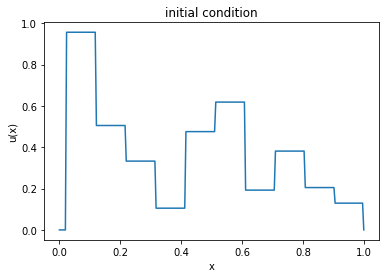

In [5]:
fig, ax = plt.subplots()
ax.plot(x_V, initial_condition(x_V))
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
plt.title("initial condition")
plt.show()

What is left to do is only to iterate over the profiles and some values for the parameter. The results are collected in a snpshot matrix X which is then decomposed using the SVD.

In [6]:
set_log_active(False)
X = np.zeros((m, n))
for i in range(n):
    # Compute solution
    solve(a == L, u, bcs)
    X[:, i] = u.vector().vec().array
    u_1.assign(u)

In [7]:
U, S, VT = np.linalg.svd(X, full_matrices=False)
X_approx = np.matmul(U * S, VT)
print("machine precision of SVD?:", np.allclose(X_approx, X))

machine precision of SVD?: True


## Visualizations:

Plot u(x)

In [8]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['font.size'] = 24

In [9]:
def plot_snapshots_lines(X):
    m, n = X.shape
    fig, ax = plt.subplots()
    for i in range(n):
        if i%10 == 0:
            ax.plot(x_V, X[:, i])
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    plt.title("some snapshots in the database")
    plt.show()

    
def plot_snapshots_2D(X):
    fig, ax = plt.subplots()
    ax.imshow(X, interpolation="nearest")
    ax.set_aspect("auto")
    ax.set_xlabel("snapshot #")
    ax.set_ylabel("node #")
    plt.title("snapshot matrix")
    plt.show()

    
def plot_singular_values(X):
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    #print(S)
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(0, len(S)), S, "k.-", label="sv")
    ax1.set_xlabel("rank r")
    ax1.set_ylabel("singular values")
    ax1.set_yscale('log')
    ax1.set_ylim([1e-16, 1e2])
    ax1.grid(which="both")
    plt.suptitle("dacay of the singular values")
    #plt.grid()
    plt.tight_layout()
    plt.show()
    return S

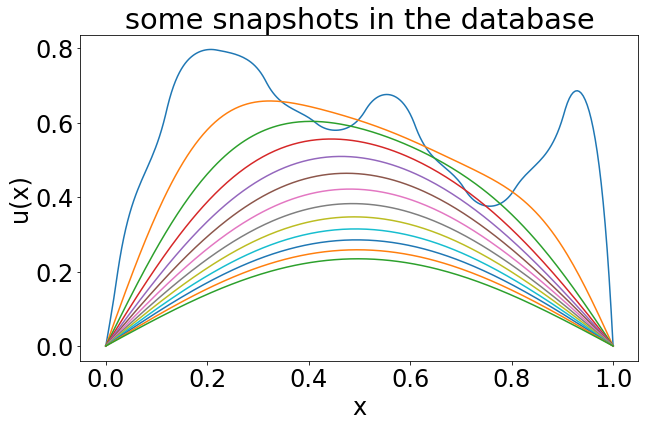

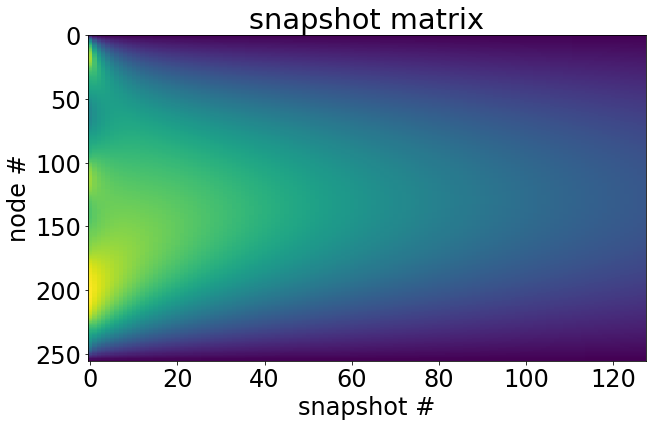

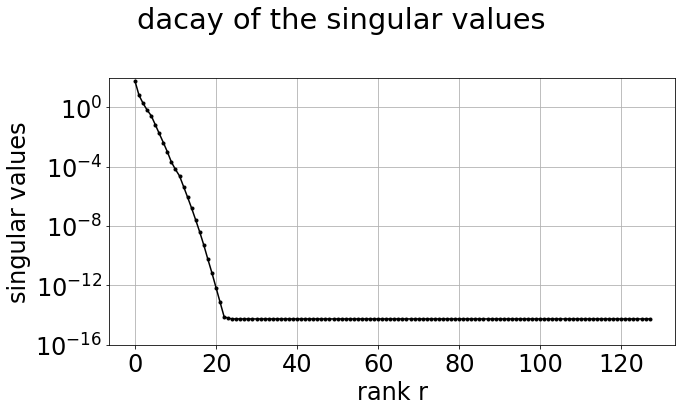

In [10]:
plot_snapshots_lines(X)
plot_snapshots_2D(X)
S_diff = plot_singular_values(X)

# Advection
$$
u =    \begin{cases}
      1 & \text{$ x \leq \frac{n}{N}$}\\
      0 & \text{otherwise}
    \end{cases} 
$$
\frac{n-1}{N} \leq

In [11]:
for i in range(m):
    for j in range(n):
        if (x_V[i] <= j/n):#((j-1)/n <= x_V[i]) and (x_V[i] <= j/n):
            X[i, j] = 1.0
        else:
            X[i, j] = 0.0

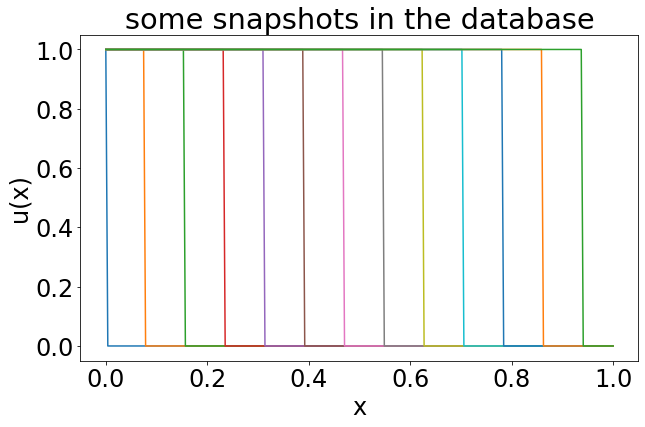

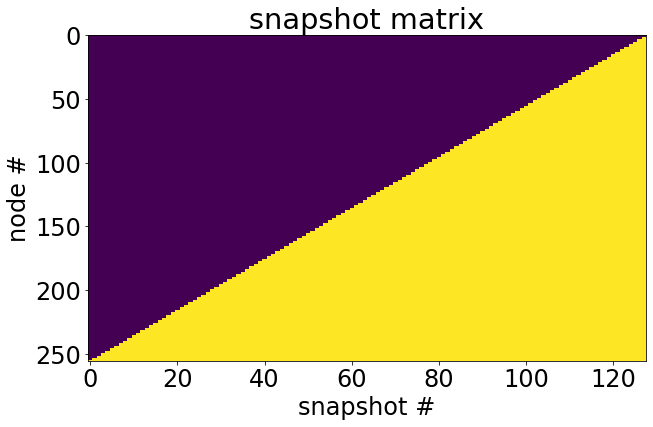

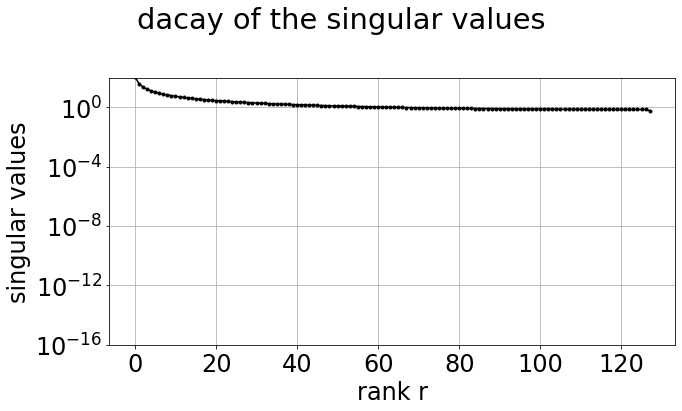

In [12]:
plot_snapshots_lines(X)
plot_snapshots_2D(X)
S_adv1 = plot_singular_values(X)

$$
u(x) = \exp^{-1000  (x+\frac{j}{n-1})²}
$$

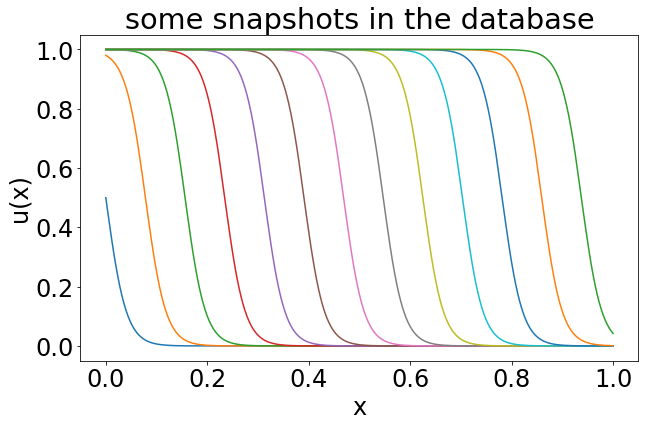

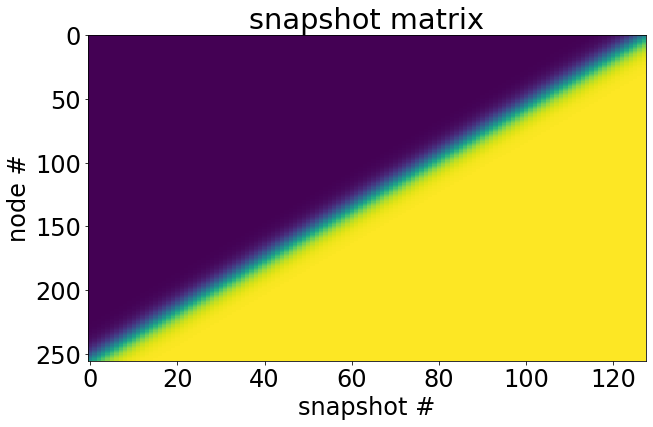

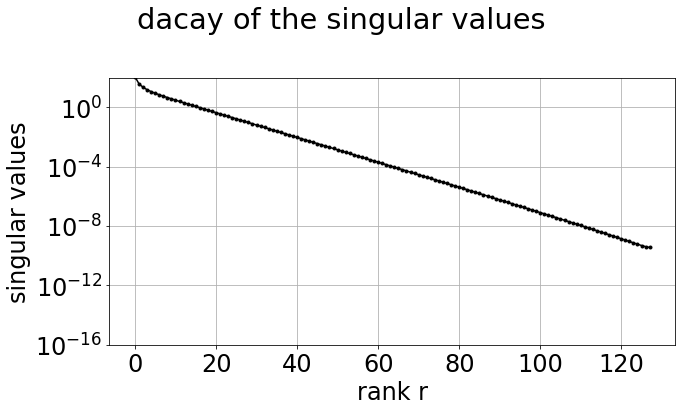

In [13]:
#def linear(x, time):
#    y = -10*(x-time)+1
#    y[y>1] = 1
#    y[y<0] = 0
#    return y

def sigmoid(x, time):
    return 1.0 / (1+np.e**((x-time)*50))

for j in range(n):
    X[:, j] = sigmoid(x_V, time=j/n)


plot_snapshots_lines(X)
plot_snapshots_2D(X)
S_adv2 = plot_singular_values(X)

$$
u(x) = \exp^{-200  (x+\frac{j}{n-1})²}
$$

In [14]:
def gauss(x, time):
    y = np.e**(-200 * (x+time)**2)
    return y


for i in range(m):
    for j in range(n):
        X[i, j] = gauss(x_V[i], time=j/n-1)


#plot_snapshots_lines(X)
#plot_snapshots_2D(X)
#S_adv3 = plot_singular_values(X)

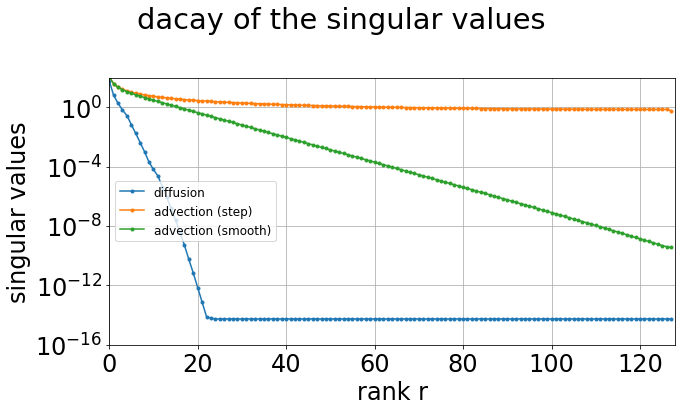

/tmp/ipykernel_75062/3543453526.py:25: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(n, 1/(2*n**.5), "r--", label="1/(2*n**.5)")


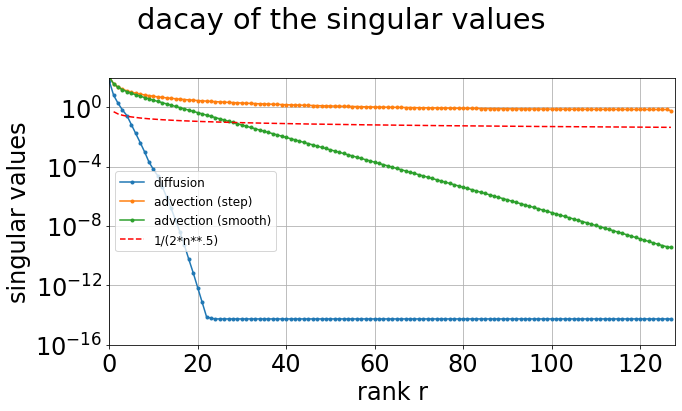

/tmp/ipykernel_75062/3543453526.py:44: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(n, 1/(2*n**.5), "r--", label="1/(2*n**.5)")


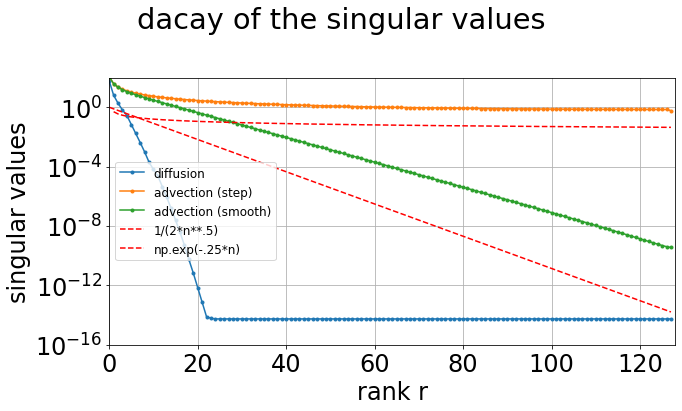

In [152]:
fig, ax1 = plt.subplots()
lbls = ["diffusion", "advection (step)", "advection (smooth)"]
for i, S in enumerate([S_diff, S_adv1, S_adv2]):
    ax1.plot(np.arange(0, len(S)), S, ".-", label=lbls[i])
n = np.arange(0, len(S))
#ax1.plot(n, 1/(2*n**.5), "r--", label="1/(2*n**.5)")
#ax1.plot(n, np.exp(-.25*n), "r--", label="np.exp(-.25*n)")
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax1.set_yscale('log')
ax1.set_xlim([0, len(S)])
ax1.set_ylim([1e-16, 1e2])
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
#plt.grid()
plt.legend(prop={'size': 12})
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots()
lbls = ["diffusion", "advection (step)", "advection (smooth)"]
for i, S in enumerate([S_diff, S_adv1, S_adv2]):
    ax1.plot(np.arange(0, len(S)), S, ".-", label=lbls[i])
n = np.arange(0, len(S))
ax1.plot(n, 1/(2*n**.5), "r--", label="1/(2*n**.5)")
#ax1.plot(n, np.exp(-.25*n), "r--", label="np.exp(-.25*n)")
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax1.set_yscale('log')
ax1.set_xlim([0, len(S)])
ax1.set_ylim([1e-16, 1e2])
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
#plt.grid()
plt.legend(prop={'size': 12})
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots()
lbls = ["diffusion", "advection (step)", "advection (smooth)"]
for i, S in enumerate([S_diff, S_adv1, S_adv2]):
    ax1.plot(np.arange(0, len(S)), S, ".-", label=lbls[i])
n = np.arange(0, len(S))
ax1.plot(n, 1/(2*n**.5), "r--", label="1/(2*n**.5)")
ax1.plot(n, np.exp(-.25*n), "r--", label="np.exp(-.25*n)")
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax1.set_yscale('log')
ax1.set_xlim([0, len(S)])
ax1.set_ylim([1e-16, 1e2])
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
#plt.grid()
plt.legend(prop={'size': 12})
plt.tight_layout()
plt.show()


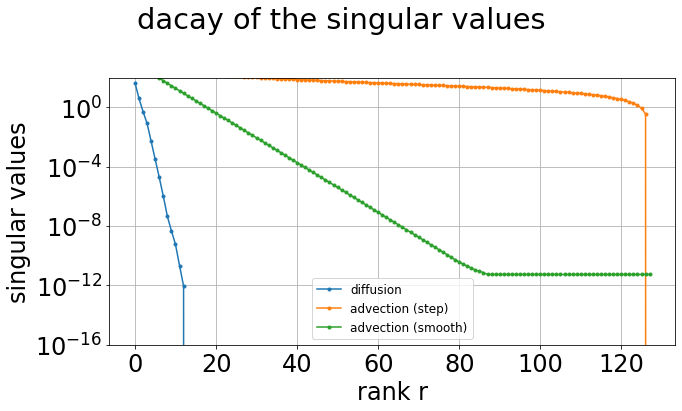

In [153]:

fig, ax1 = plt.subplots()
lbls = ["diffusion", "advection (step)", "advection (smooth)"]
for i, S in enumerate([S_diff, S_adv1, S_adv2]):
    residual = np.sum(S**2) - np.cumsum(S**2)
    ax1.plot(np.arange(0, len(S)), residual, ".-", label=lbls[i])
n = np.arange(0, len(S))
#ax1.plot(n, 1/(2*n**.5), "r--", label="1/(2*n**.5)")
#ax1.plot(n, np.exp(-.25*n), "r--", label="np.exp(-.25*n)")
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax1.set_yscale('log')
#ax1.set_xlim([0, len(S)])
ax1.set_ylim([1e-16, 1e2])
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
#plt.grid()
plt.legend(prop={'size': 12})
plt.tight_layout()
plt.show()

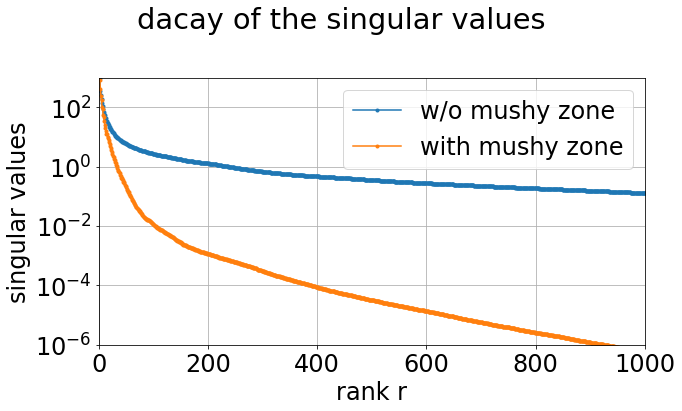

In [115]:
path = "/home/florianma@ad.ife.no/ad_disk/Florian/CavitySolidification/"
fig, ax1 = plt.subplots()
for i, prefix in enumerate(["mul1e6", "div10"]): #, "ref", "mul10", "mul100", "mul1000", "mul10000", "mul100000"]):
    S = np.load(path+prefix+"/Xn_S.npy")
    ax1.plot(np.arange(0, len(S)), S, ".-", label=["w/o mushy zone", "with mushy zone", "ref","",";","..", "", "", ""][i])
#n = np.arange(0, len(S))
#ax1.plot(n, 1/(2*n**.5), "r--", label="sv")
#ax1.plot(n, np.exp(-.25*n), "r--", label="sv")
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax1.set_yscale('log')
ax1.set_xlim([0, 1000])
ax1.set_ylim([1e-6, 1e3])
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
#plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

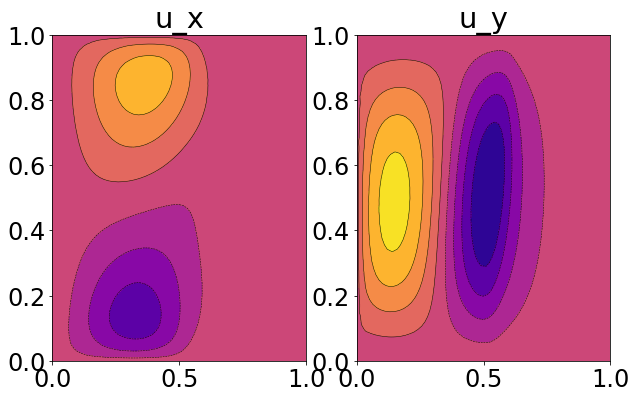

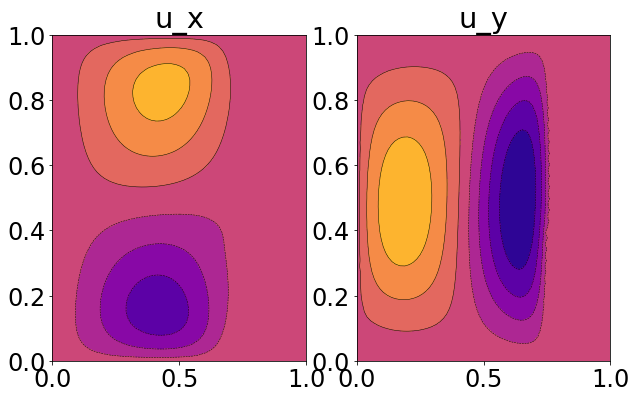

In [119]:
path = "/home/florianma@ad.ife.no/ad_disk/Florian/CavitySolidification/"
#fig, ax1 = plt.subplots()
for i, prefix in enumerate(["div10", "mul1e6"]):
    x = np.load(path+prefix+"/Tamb570_x.npy")
    y = np.load(path+prefix+"/Tamb570_y.npy")
    u = np.load(path+prefix+"/Tamb570_velocity.npy")
    sample = 500
    minmax = max(-u[sample].min(), u[sample].max())
    u /= minmax
    minmax = 1
    levels = np.linspace(-1, 1, 10)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    triang = tri.Triangulation(x, y)
    cntr = ax1.tricontour(x, y, u[sample, :3013], levels=levels, colors='black', linewidths=.5, vmin=-minmax, vmax=minmax)
    cntr = ax2.tricontour(x, y, u[sample, 3013:], levels=levels, colors='black', linewidths=.5, vmin=-minmax, vmax=minmax)

    cntr = ax1.tricontourf(x, y, u[sample, :3013], levels=levels, cmap=plt.cm.plasma, vmin=-minmax, vmax=minmax)
    cntr = ax2.tricontourf(x, y, u[sample, 3013:], levels=levels, cmap=plt.cm.plasma, vmin=-minmax, vmax=minmax)
    ax1.set_title("u_x")
    ax2.set_title("u_y")
    #plt.colorbar(cntr)
    plt.show()

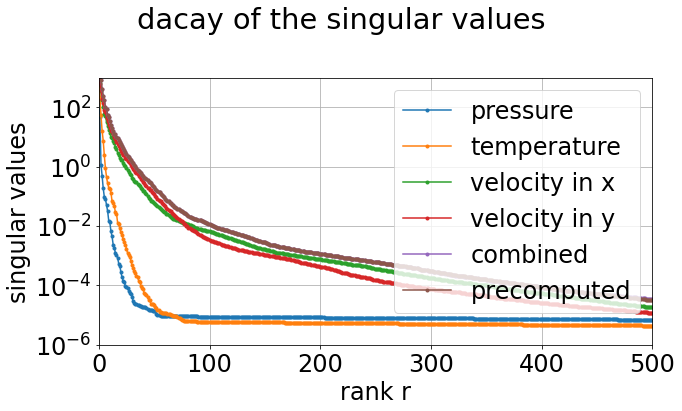

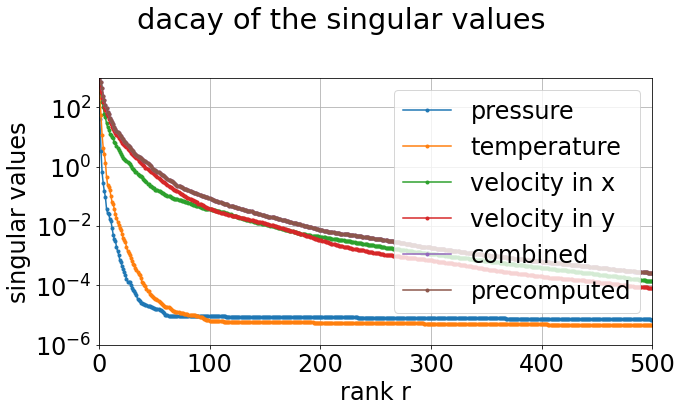

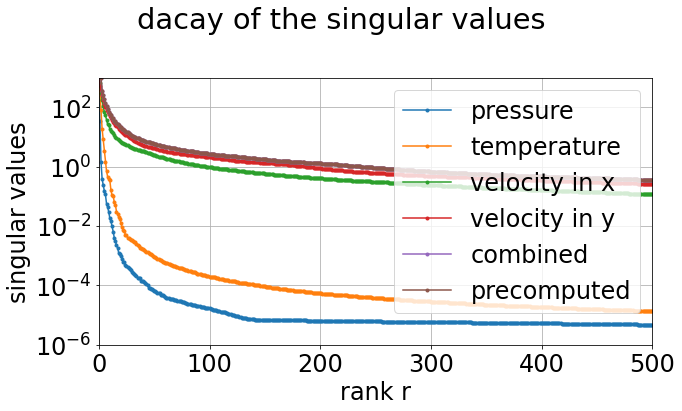

In [140]:
path = "/home/florianma@ad.ife.no/ad_disk/Florian/CavitySolidification/"


def fast_SVD(X):
    m, n = X.shape
    if m > n:
        XTX = np.matmul(np.transpose(X), X)  # 17
        S2, V2 = np.linalg.eigh(XTX)  # 47
        ll = S2 > 0
        S2 = S2[ll]
        V2 = V2[:, ll]
        S2 = S2**.5
        order2 = np.argsort(-S2)
        S2 = S2[order2]
        V2 = V2[:, order2]  # 3
        U2 = np.matmul(X, V2 / S2)  # 31
        VT2 = np.transpose(V2)
        U, S, VT = U2, S2, VT2
    else:
        XXT = np.matmul(X, np.transpose(X))
        S3, U3 = np.linalg.eigh(XXT)
        ll = S3 > 0
        S3 = S3[ll]
        U3 = U3[:, ll]
        S3 = S3**.5
        order3 = np.argsort(-S3)
        S3 = S3[order3]
        U3 = U3[:, order3]
        VT3 = np.matmul(np.transpose(U3) * 1 / S3[:, None], X)
        U, S, VT = U3, S3, VT3
    return U, S, VT

def normalize(X):
    X_min = X.min(axis=1)[:, None]  # n
    X_max = X.max(axis=1)[:, None]  # n
    X_range = X_max - X_min
    X_range[X_range < 1e-6] = 1e-6
    return (X - X_min) / X_range

res = [None, None, None]
for i, prefix in enumerate(["div10", "ref", "mul1e6"]):
    x = np.load(path+prefix+"/Tamb570_x.npy")
    y = np.load(path+prefix+"/Tamb570_y.npy")
    p = normalize(np.load(path+prefix+"/Tamb570_pressure.npy").T)
    t = normalize(np.load(path+prefix+"/Tamb570_temperature.npy").T)
    uv = np.load(path+prefix+"/Tamb570_velocity.npy")
    u = normalize(uv[:, :3013].T)
    v = normalize(uv[:, 3013:].T)
    _, S_p, _ = fast_SVD(p)
    _, S_t, _ = fast_SVD(t)
    _, S_u, _ = fast_SVD(u)
    _, S_v, _ = fast_SVD(v)
    _, S_all, _ = fast_SVD(np.r_[p, t, u, v])
    S_pre = np.load(path+prefix+"/Xn_S.npy")
    res[i] = [S_p, S_t, S_u, S_v, S_all]

    fig, ax1 = plt.subplots()
    for i, S in enumerate([S_p, S_t, S_u, S_v, S_all, S_pre]):
        ax1.plot(np.arange(0, len(S)), S, ".-", label=["pressure", "temperature", "velocity in x", "velocity in y", "combined", "precomputed"][i])
    ax1.set_xlabel("rank r")
    ax1.set_ylabel("singular values")
    ax1.set_yscale('log')
    ax1.set_xlim([0, 500])
    ax1.set_ylim([1e-6, 1e3])
    ax1.grid(which="both")
    plt.suptitle("dacay of the singular values")
    plt.tight_layout()
    plt.legend()
    plt.show()

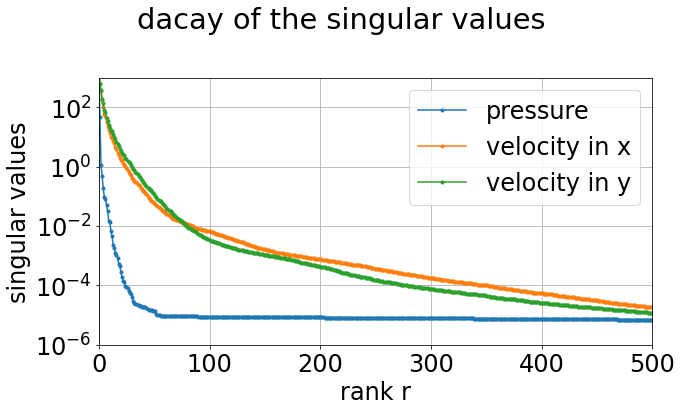

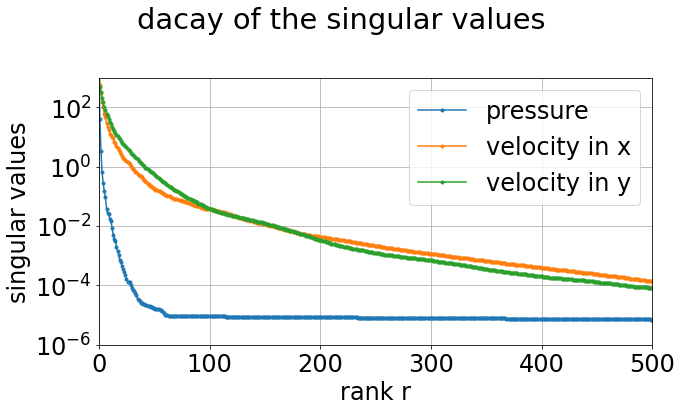

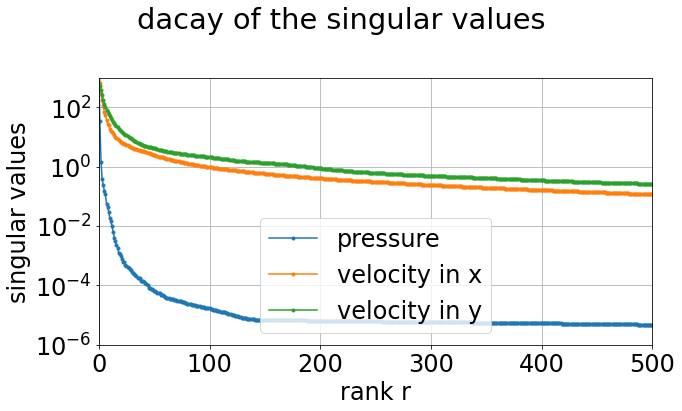

In [141]:
for i, prefix in enumerate(["div10", "ref", "mul1e6"]):
    S_p, S_t, S_u, S_v, S_all = res[i]

    fig, ax1 = plt.subplots()
    for i, S in enumerate([S_p, S_u, S_v]): # S_t, S_all, S_pre
        ax1.plot(np.arange(0, len(S)), S, ".-", label=["pressure", "velocity in x", "velocity in y"][i])
    ax1.set_xlabel("rank r")
    ax1.set_ylabel("singular values")
    ax1.set_yscale('log')
    ax1.set_xlim([0, 500])
    ax1.set_ylim([1e-6, 1e3])
    ax1.grid(which="both")
    plt.suptitle("dacay of the singular values")
    plt.tight_layout()
    plt.legend()
    plt.show()

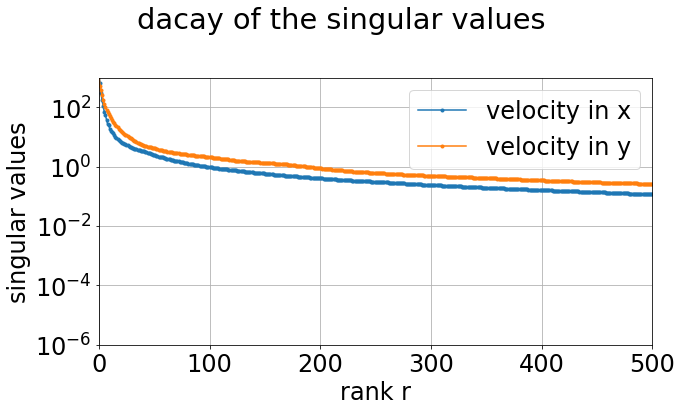

In [142]:

fig, ax1 = plt.subplots()
for i, S in enumerate([S_u, S_v]): # S_t, S_all, S_pre
    ax1.plot(np.arange(0, len(S)), S, ".-", label=["velocity in x", "velocity in y"][i])
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax1.set_yscale('log')
ax1.set_xlim([0, 500])
ax1.set_ylim([1e-6, 1e3])
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
plt.tight_layout()
plt.legend()
plt.show()